In [1]:
from pathlib import Path
from collections import Counter

import bw2data as bd
import bw2io as bi
import bw2analyzer as bwa
from bw2io.importers.bonsai import BonsaiImporter

10:02:14+0200 [warning  ] Can't import `SimaProBlockCSVImporter` - please install `bw2io` with `pip install bw2io[multifunctional]` or install `multifunctional` and `bw_simapro_csv` manually.


## basic setup

In [2]:
if 'bonsai_test' not in bd.projects:
    bi.remote.install_project('ecoinvent-3.10-biosphere','bonsai_test')

bd.projects.set_current('bonsai_test')

## importing BONSAI

In [3]:
bonsai_data_path = Path("bonsai_files")

In [4]:
biosphere_db = bd.Database(bd.config.biosphere)

In [5]:
# mapping between elements in the intervention matrix and the biosphere database
co_fossil = biosphere_db.get(name='Carbon monoxide, fossil',
                                     categories=('air',))
co2_non_fossil = biosphere_db.get(name='Carbon dioxide, non-fossil',
                                     categories=('air',))
co2_fossil = biosphere_db.get(name='Carbon dioxide, fossil',
                                     categories=('air',))
ch4_fossil = biosphere_db.get(name='Methane, fossil',
                                     categories=('air',))
ch4_non_fossil = biosphere_db.get(name='Methane, non-fossil',
                                     categories=('air',))
n2o = biosphere_db.get(name='Dinitrogen monoxide',
                                     categories=('air',))

In [6]:
map_bonsai_b3 = {'Carbon_dioxide__fossil_Air': co2_fossil['code'],
 'Carbon_dioxide__biogenic_Air': co2_non_fossil['code'],
 'Methane__fossil_Air': ch4_fossil['code'],
 'Methane__biogenic_Air': ch4_non_fossil['code'],
 'Carbon_monoxide__fossil_Air':co2_non_fossil['code'],
 'Dinitrogen_monoxide_Air':n2o['code'],
 }

In [7]:
importer = BonsaiImporter(dirpath=bonsai_data_path,
                          db_name='bonsai',
                          b3mapping=map_bonsai_b3,
                          )

In [8]:
importer.write_database()

no extra biosphere flows added
10:03:11+0200 [warning  ] Not able to determine geocollections for all datasets. This database is not ready for regionalization.


100%|██████████| 42088/42088 [00:07<00:00, 5880.39it/s]


10:03:22+0200 [info     ] Vacuuming database            
10:03:33+0200 [info     ] Starting IO table write       
10:03:36+0200 [info     ] Adding technosphere matrix    
10:03:41+0200 [info     ] Adding biosphere matrix       
10:03:42+0200 [info     ] Finalizing serialization      


In [9]:
bd.databases

Databases dictionary with 3 object(s):
	bonsai
	bonsai biosphere
	ecoinvent-3.10-biosphere

## general overview

In [10]:
bonsai_db = bd.Database('bonsai')

In [11]:
# this is a "lighter" backend since metadata on the exchanges was not needed
bonsai_db.backend

'iotable'

In [12]:
len(bonsai_db)

42088

In [13]:
n_locations = len({act['location'] for act in bonsai_db})

In [14]:
print(f"{n_locations} different locations")

50 different locations


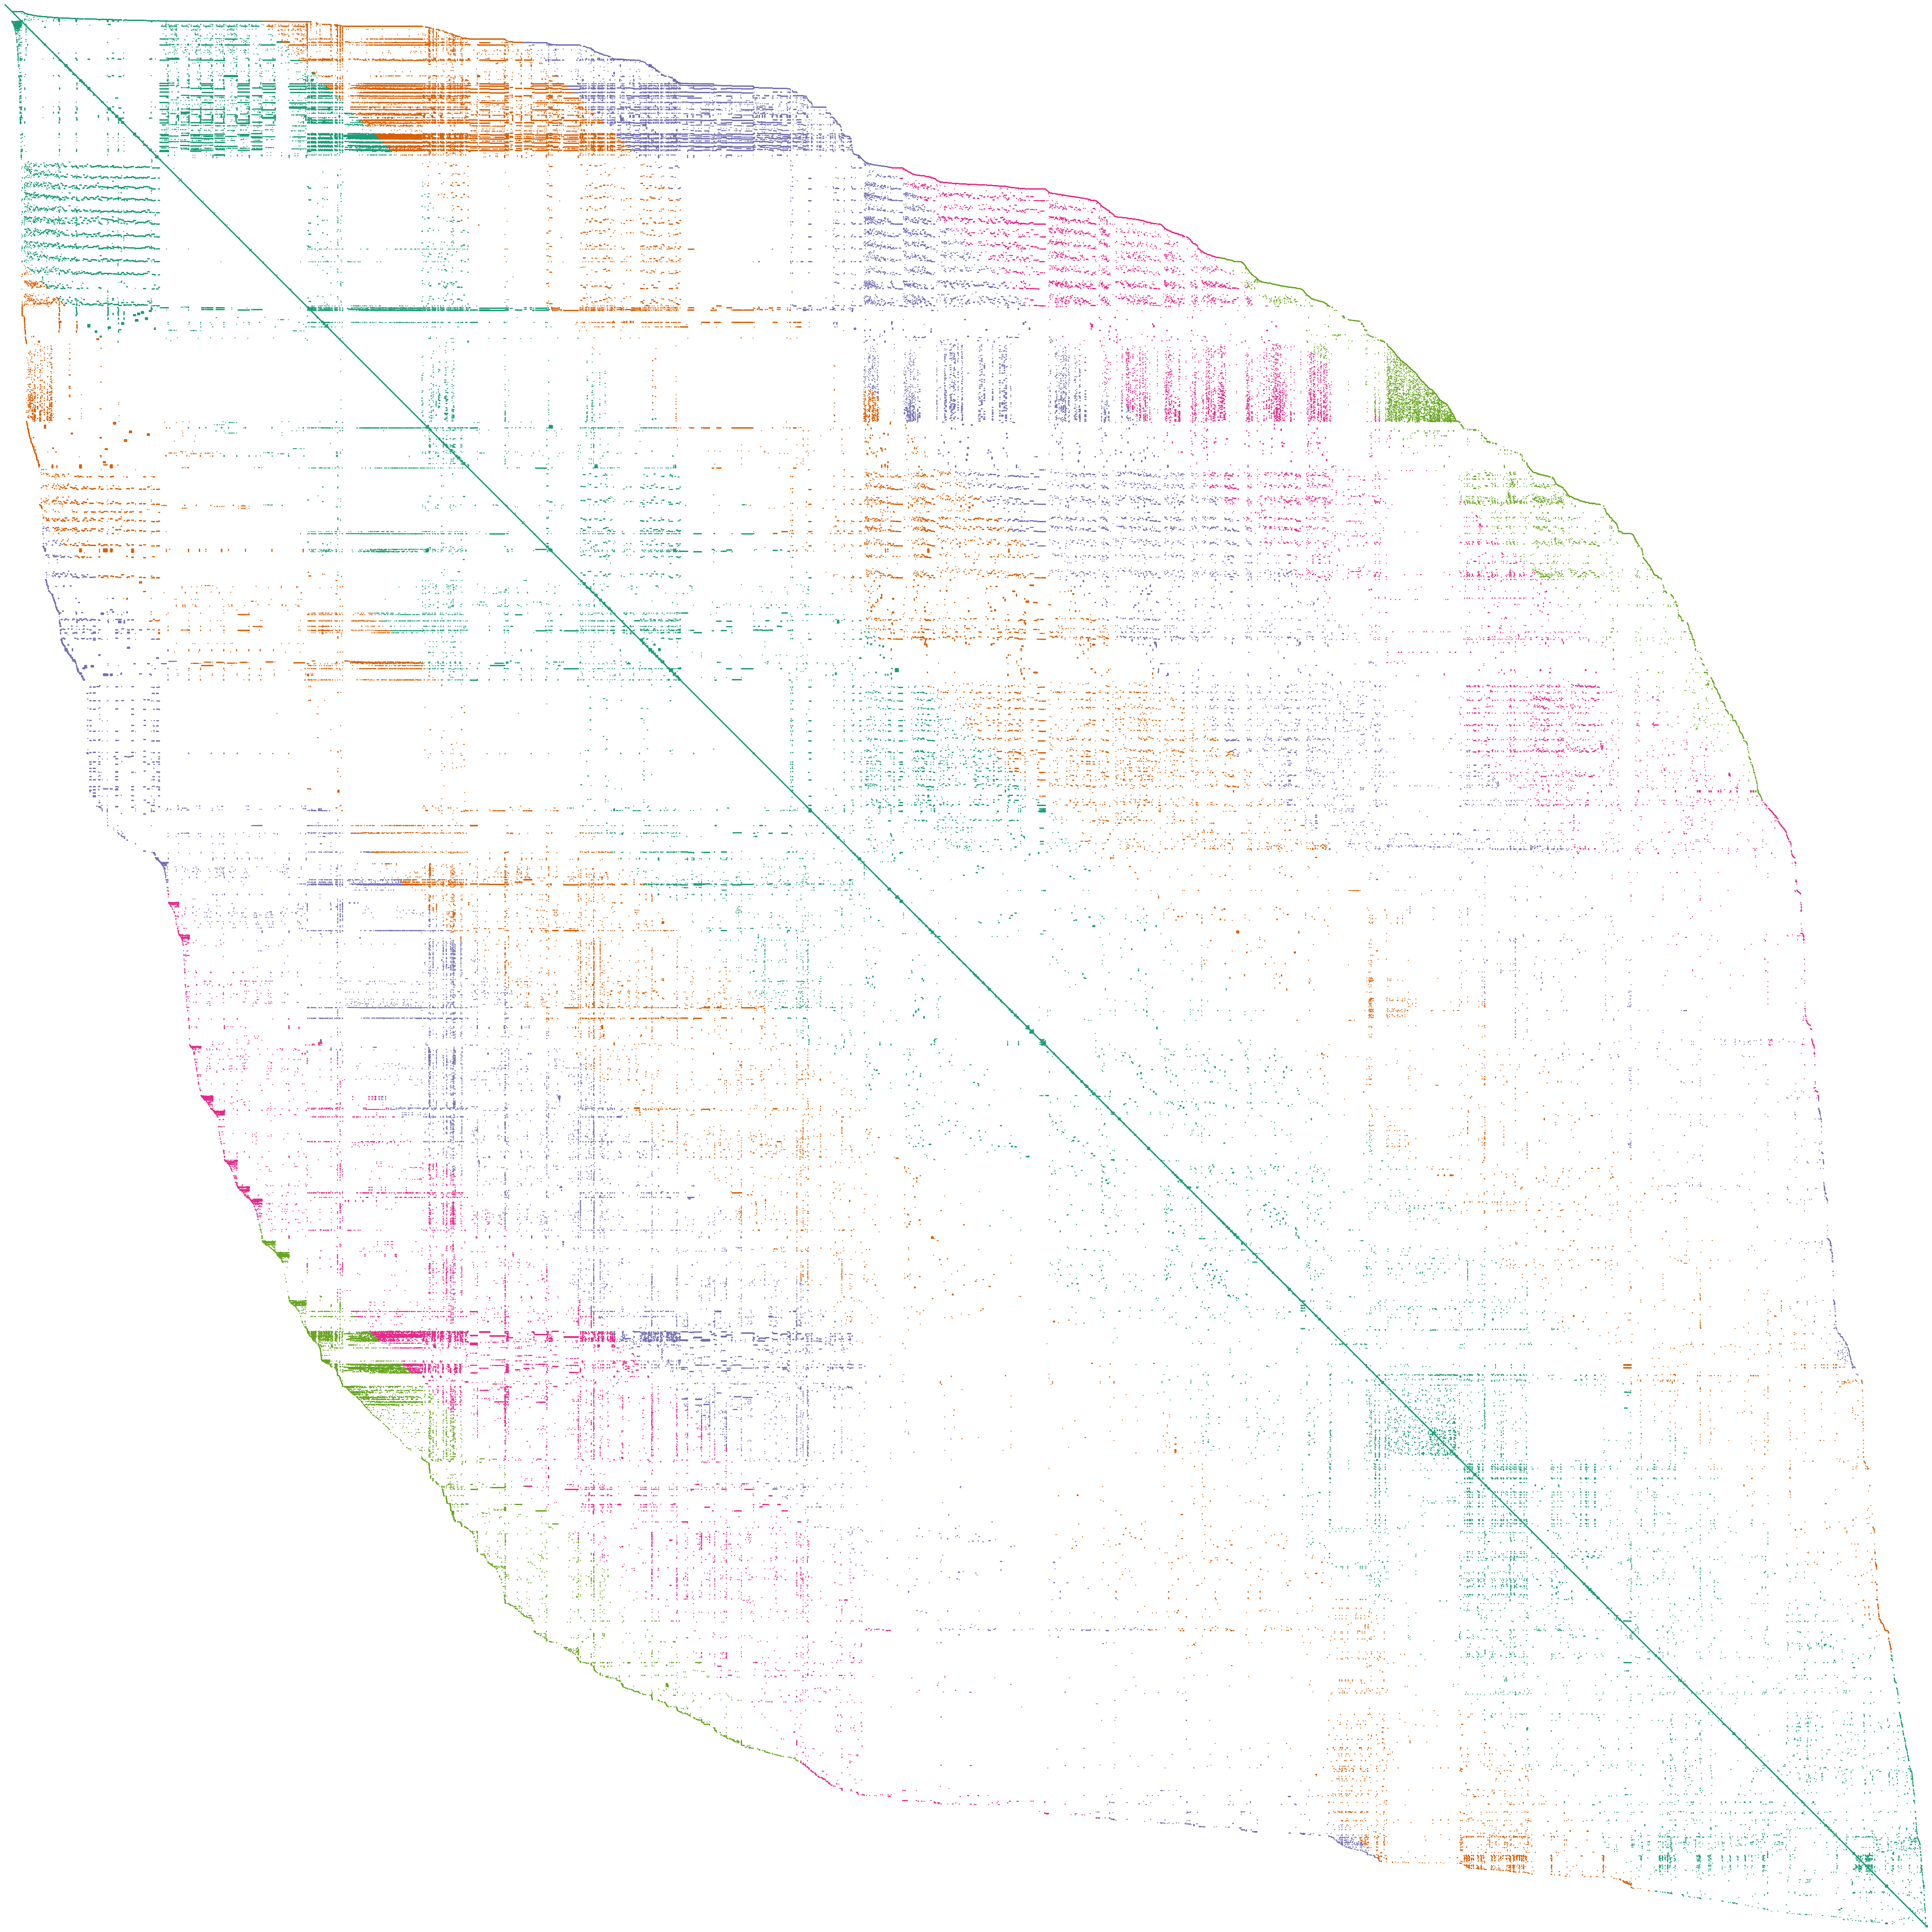

In [15]:
bonsai_db.graph_technosphere()

relatively dense database

## calculating a carbon footprint

In [16]:
act = bonsai_db.random()
act

'production of juice of citrus fruit n.e.c.' (tonnes, GR, None)

In [17]:
# some metadata available, to be improved
act.as_dict()

{'production volume': 360.7898011639524,
 'location': 'GR',
 'code': 'A_Juic_nes|GR',
 'unit': 'tonnes',
 'reference product': 'juice of citrus fruit n.e.c.',
 'name': 'production of juice of citrus fruit n.e.c.',
 'database': 'bonsai',
 'type': 'processwithreferenceproduct',
 'id': 236036118631378988}

bear in mind units are often different from ecoinvent! the default unit of mass is tonne and of energy TJ !

In [18]:
gwp100 = ('IPCC 2021', 'climate change', 'global warming potential (GWP100)')

In [19]:
lca = act.lca(gwp100)

In [20]:
lca.score

1346.0933093657789

In [21]:
characterized_inventory = lca.to_dataframe(matrix_label='characterized_inventory')

In [22]:
# e.g. contribution by elementary flow
characterized_inventory.pivot_table(index='row_name',
                                    values='amount',
                                    aggfunc='sum')

,amount
row_name,
"Carbon dioxide, fossil",1284.372729
Dinitrogen monoxide,24.567264
"Methane, fossil",20.564873
"Methane, non-fossil",0.143469


In [23]:
# contribution by location
characterized_inventory.pivot_table(index='col_location',
                                    values='amount',
                                    aggfunc='sum').sort_values(by='amount',
                                                               ascending=False).head()

,amount
col_location,
GR,926.014463
WM,173.143811
BG,54.145365
DE,31.063457
WE,20.151185


## io table backend

In [24]:
for e in act.edges():
    print(e)

Exchange: 360.789794921875 tonnes 'production of juice of citrus fruit n.e.c.' (tonnes, GR, None) to 'production of juice of citrus fruit n.e.c.' (tonnes, GR, None)>
Exchange: -0.12524396181106567 tonnes 'aluminium and aluminium products - residual (market for)' (tonnes, GR, None) to 'production of juice of citrus fruit n.e.c.' (tonnes, GR, None)>


Exchange: -0.0009172143181785941 tonnes 'bkb/peat briquettes(market for)' (tonnes, GR, None) to 'production of juice of citrus fruit n.e.c.' (tonnes, GR, None)>
Exchange: -0.16261042654514313 tonnes 'market product production of copper products' (tonnes, GR, None) to 'production of juice of citrus fruit n.e.c.' (tonnes, GR, None)>
Exchange: -0.0177678894251585 tonnes 'market product production of electrical machinery and apparatus n.e.c.' (tonnes, GR, None) to 'production of juice of citrus fruit n.e.c.' (tonnes, GR, None)>
Exchange: -1.0310078859329224 tonnes 'other fabricated metal products nec, (market for)' (tonnes, GR, None) to 'production of juice of citrus fruit n.e.c.' (tonnes, GR, None)>
Exchange: -1.6746238470077515 tonnes 'market product products of forestry, logging and related services (02)' (tonnes, GR, None) to 'production of juice of citrus fruit n.e.c.' (tonnes, GR, None)>
Exchange: -0.33127373456954956 tonnes 'market product production of machinery and equipment n.e.c